# Demand Forecasting - Exploratory Analysis

Este notebook realiza un análisis exploratorio del sistema de pronóstico de demanda.


In [2]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.forecasting.data import generate_synthetic_demand, load_data
from src.forecasting.features import create_all_features, get_feature_columns
from src.forecasting.models import DemandForecaster
from src.forecasting.evaluate import calculate_metrics

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline


## 1. Generación y visualización de datos


In [3]:
df = generate_synthetic_demand(periods=730)
print(f"Shape: {df.shape}")
df.head()


Shape: (730, 2)


,date,demand
0,2023-01-01,102.483571
1,2023-01-02,111.430182
2,2023-01-03,118.650323
3,2023-01-04,115.305093
4,2023-01-05,93.896085


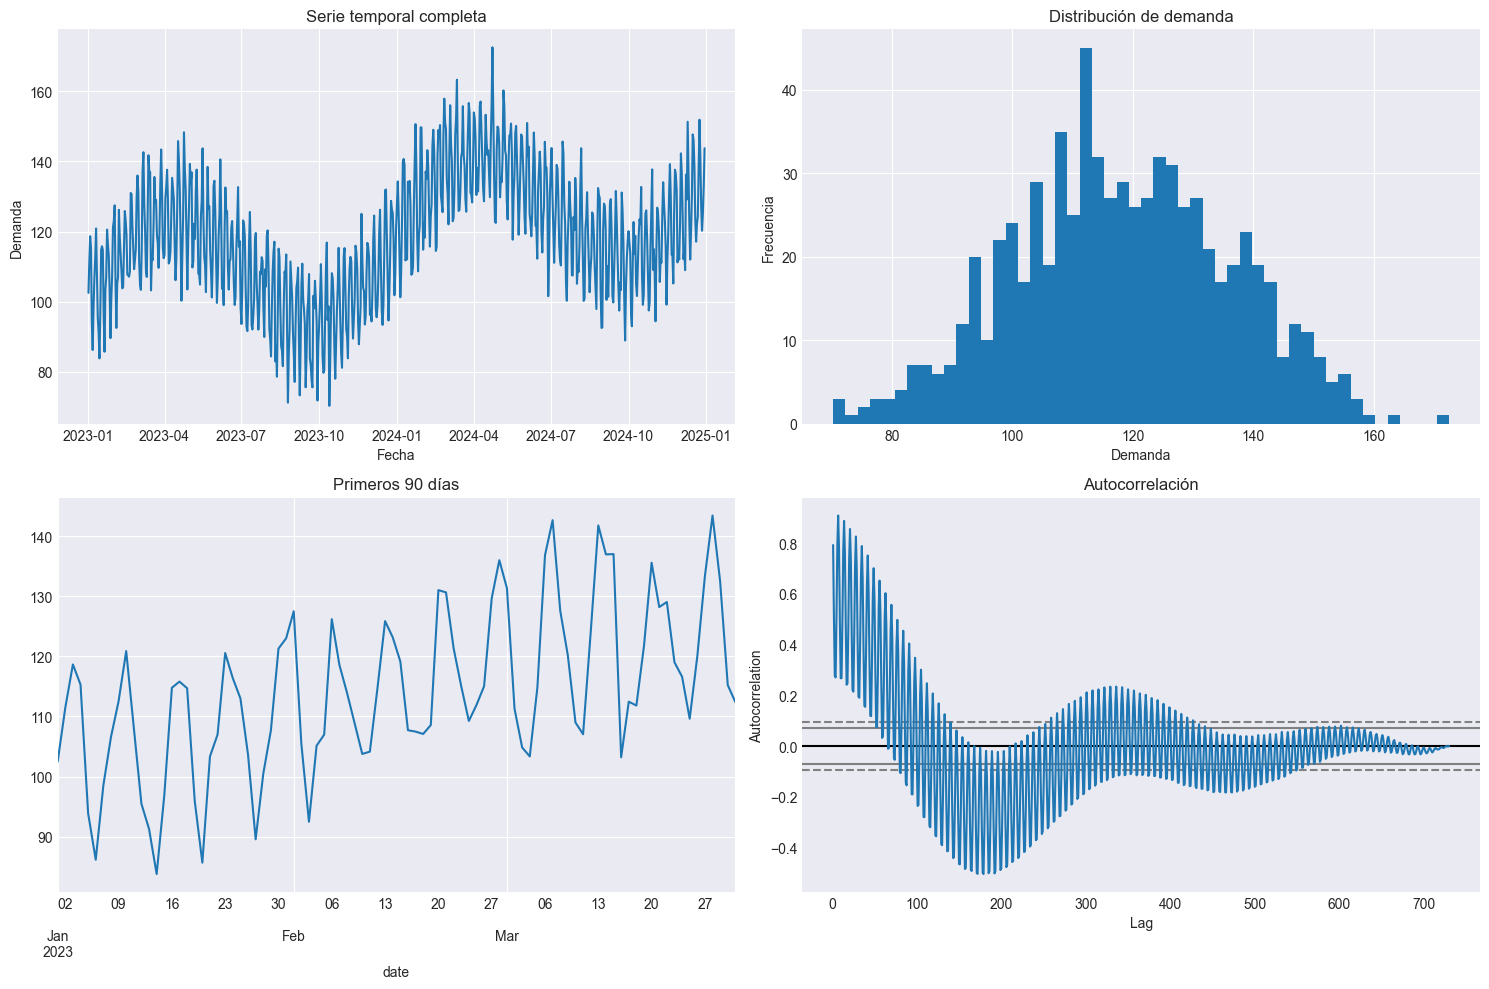

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(df["date"], df["demand"])
axes[0, 0].set_title("Serie temporal completa")
axes[0, 0].set_xlabel("Fecha")
axes[0, 0].set_ylabel("Demanda")

df["demand"].hist(bins=50, ax=axes[0, 1])
axes[0, 1].set_title("Distribución de demanda")
axes[0, 1].set_xlabel("Demanda")
axes[0, 1].set_ylabel("Frecuencia")

df.set_index("date")["demand"].iloc[:90].plot(ax=axes[1, 0])
axes[1, 0].set_title("Primeros 90 días")

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df["demand"], ax=axes[1, 1])
axes[1, 1].set_title("Autocorrelación")

plt.tight_layout()
plt.show()


## 2. Estadísticas descriptivas


In [5]:
print("Estadísticas descriptivas:")
print(df["demand"].describe())
print(f"\nCoeficiente de variación: {df['demand'].std() / df['demand'].mean():.2%}")


Estadísticas descriptivas:
count    730.000000
mean     118.171072
std       17.934078
min       70.226699
25%      105.489564
50%      117.711515
75%      130.962328
max      172.573701
Name: demand, dtype: float64

Coeficiente de variación: 15.18%


## 3. Feature engineering


In [6]:
df_features = create_all_features(df).dropna()
print(f"Shape con features: {df_features.shape}")
print(f"\nFeatures creadas: {get_feature_columns()}")


Shape con features: (700, 14)

Features creadas: ['lag_1', 'lag_7', 'lag_30', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'rolling_std_30', 'day_of_week', 'month', 'day_of_month', 'week_of_year', 'is_weekend']


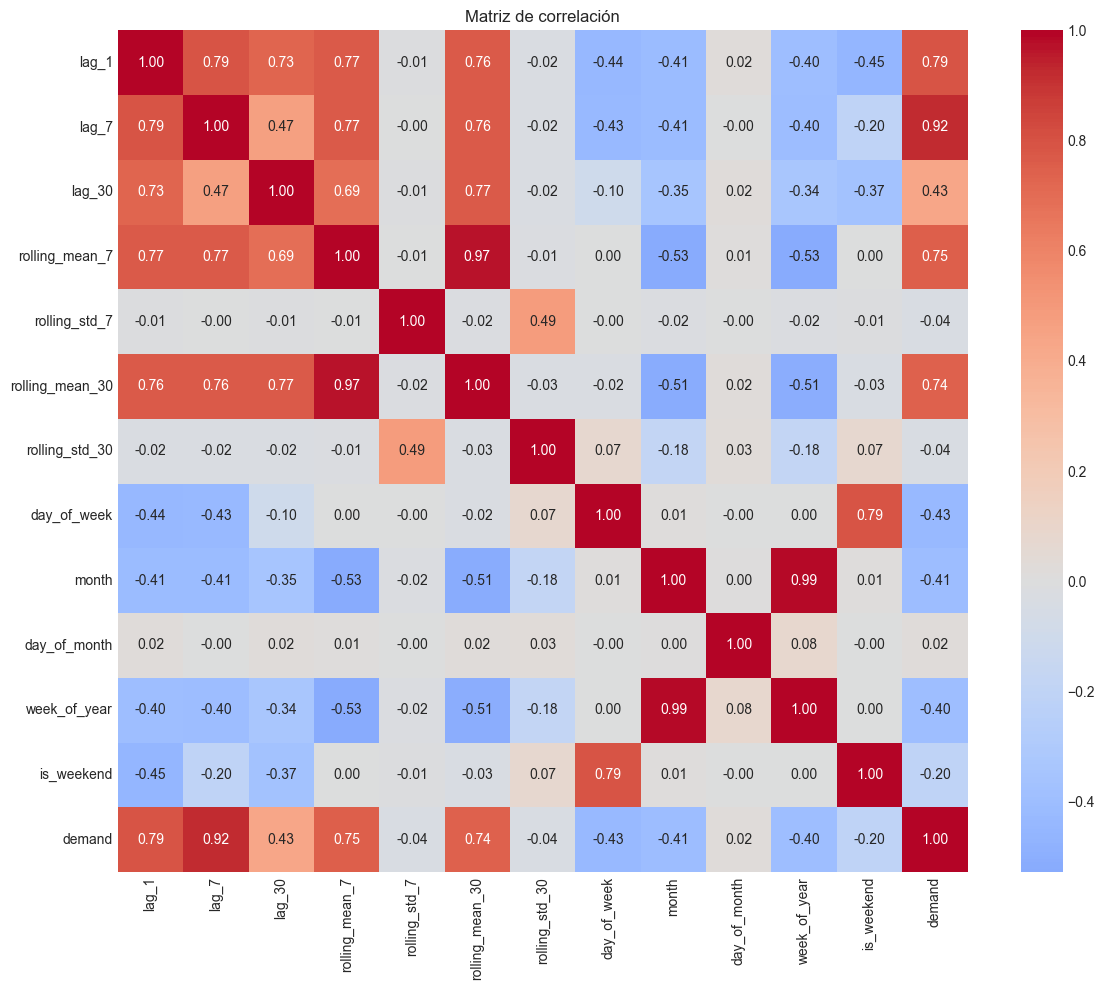

In [7]:
feature_cols = get_feature_columns()
correlation_matrix = df_features[feature_cols + ["demand"]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()


## 4. Entrenamiento del modelo


In [8]:
split_idx = int(len(df_features) * 0.8)
train_df = df_features.iloc[:split_idx]
test_df = df_features.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df["demand"]
X_test = test_df[feature_cols]
y_test = test_df["demand"]

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")


Train size: 560
Test size: 140


In [9]:
model = DemandForecaster(n_estimators=100, max_depth=20, random_state=42, n_jobs=1)
model.fit(X_train, y_train)
print("Modelo entrenado")


Modelo entrenado


## 5. Evaluación


In [10]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_metrics = calculate_metrics(y_train.values, y_pred_train)
test_metrics = calculate_metrics(y_test.values, y_pred_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df


,Train,Test
mae,2.275089,5.490059
rmse,2.922356,6.833335
mape,1.981070,4.729955
smape,1.976111,4.754367


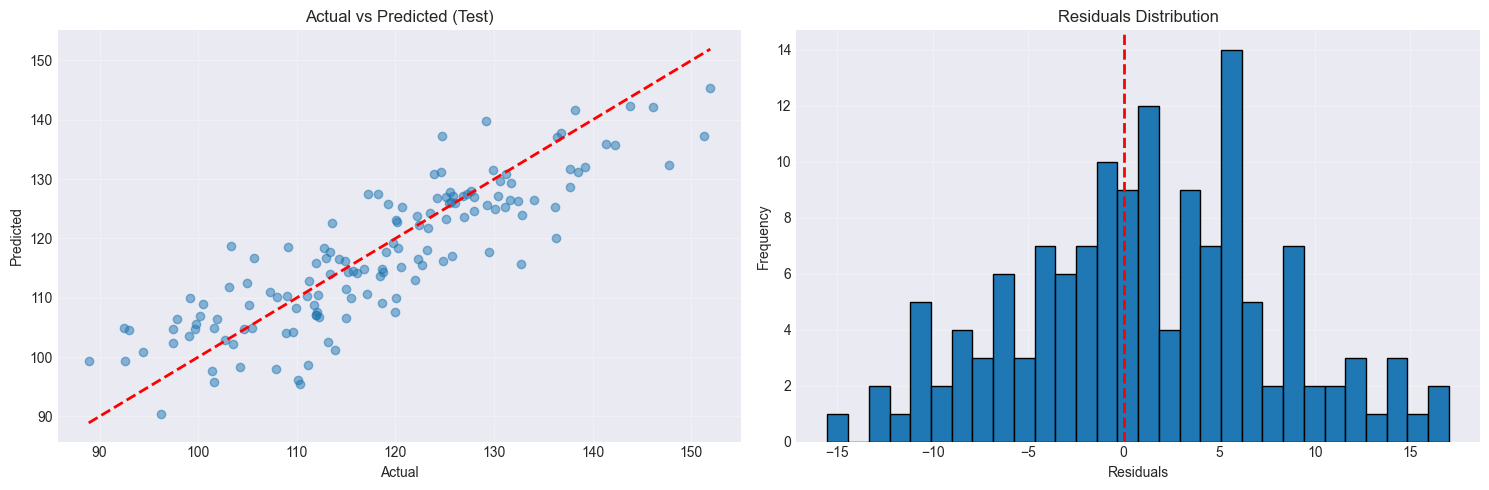

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(y_test, y_pred_test, alpha=0.5)
mn, mx = y_test.min(), y_test.max()
axes[0].plot([mn, mx], [mn, mx], "r--", lw=2)
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Actual vs Predicted (Test)")
axes[0].grid(True, alpha=0.3)

residuals = y_test.values - y_pred_test
axes[1].hist(residuals, bins=30, edgecolor="black")
axes[1].axvline(x=0, color="r", linestyle="--", lw=2)
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Residuals Distribution")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Feature importance


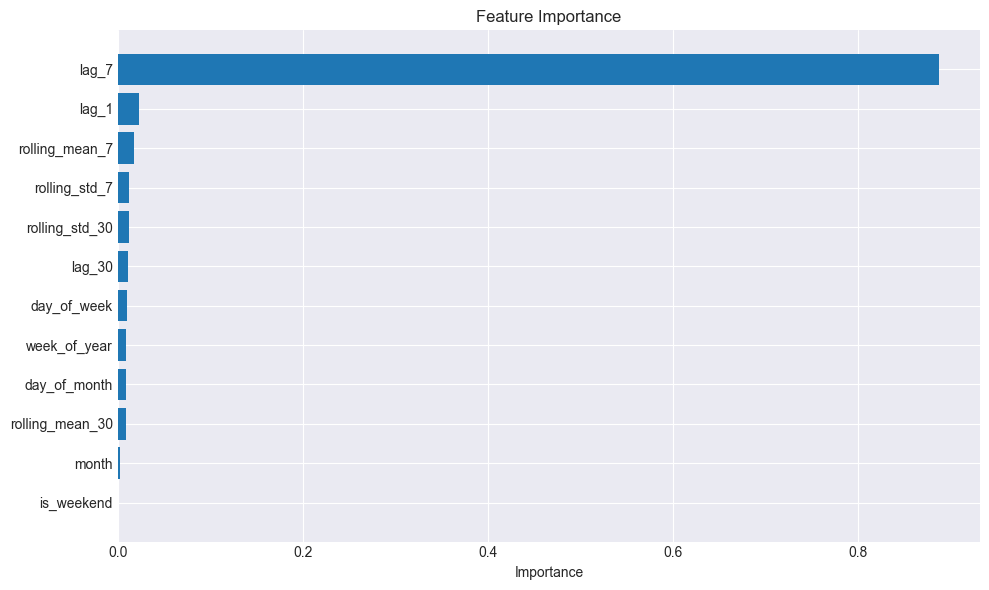

,feature,importance
1,lag_7,0.887027
0,lag_1,0.022847
3,rolling_mean_7,0.016915
4,rolling_std_7,0.012405
6,rolling_std_30,0.011860


In [12]:
importance_df = model.get_feature_importance()

plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importance_df.head()


## 7. Predicciones futuras


In [20]:
from pathlib import Path
import json

proj = Path("..").resolve()
reg_path = proj / "models" / "registry.json"

with reg_path.open() as f:
    reg = json.load(f)

mid = reg["current_model"]
rel = Path(reg["models"][mid]["path"])
model_path = (proj / rel).resolve()

print("Project root:", proj)
print("Registry exists:", reg_path.exists())
print("Current model:", mid)
print("Model path:", model_path)
print("Model exists:", model_path.exists())


Project root: C:\Users\kelly\PycharmProjects\demand-forecasting
Registry exists: True
Current model: model-20251002_223108
Model path: C:\Users\kelly\PycharmProjects\demand-forecasting\models\production\model-20251002_223108.joblib
Model exists: True


Loaded model: model-20251002_223108


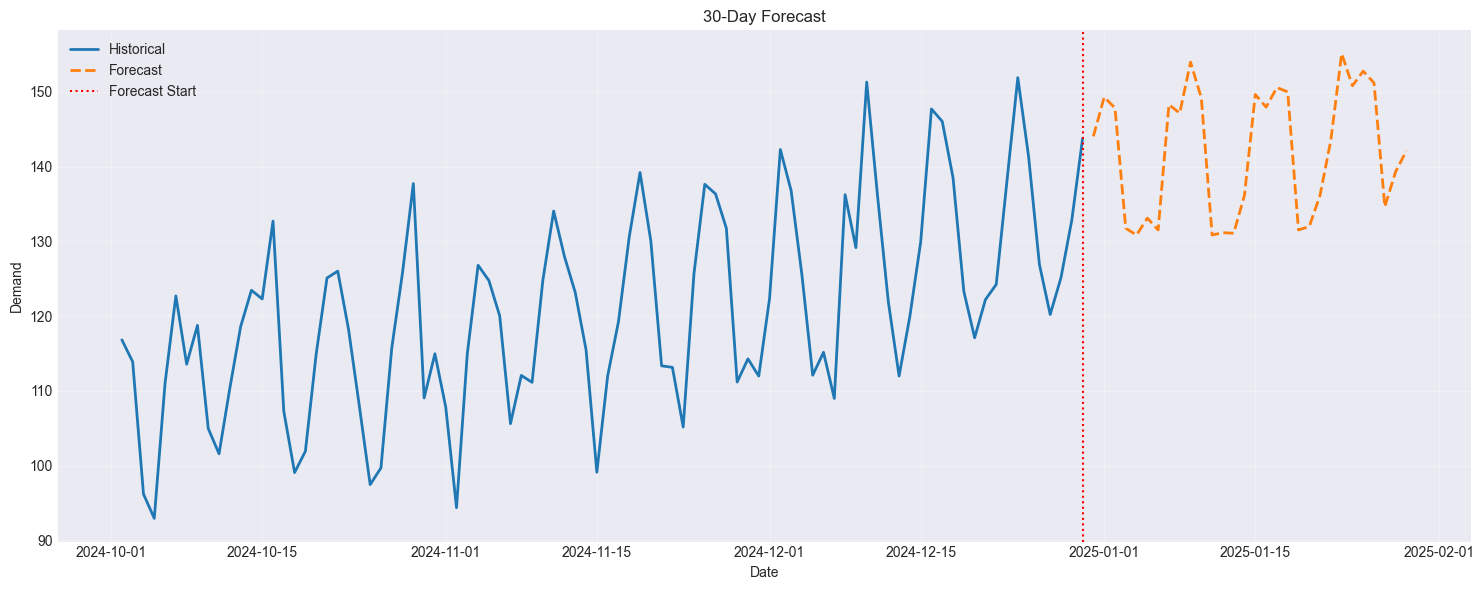

Forecast statistics:
Mean: 142.14
Std: 8.48
Min: 130.85
Max: 155.13


In [21]:
from src.forecasting.inference import DemandPredictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

tmp_reg = proj / "models" / "registry_abs.json"
reg["models"][mid]["path"] = str(model_path)

with tmp_reg.open("w") as f:
    json.dump(reg, f, indent=2)

predictor = DemandPredictor(str(tmp_reg))
future_predictions = predictor.predict_future(df, horizon=30)
future_dates = pd.date_range(start=df["date"].max() + pd.Timedelta(days=1), periods=30, freq="D")

plt.figure(figsize=(15, 6))
plt.plot(df["date"].tail(90), df["demand"].tail(90), linewidth=2, label="Historical")
plt.plot(future_dates, future_predictions, linewidth=2, linestyle="--", label="Forecast")
plt.axvline(x=df["date"].max(), color="r", linestyle=":", label="Forecast Start")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("30-Day Forecast")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Forecast statistics:")
print(f"Mean: {np.mean(future_predictions):.2f}")
print(f"Std: {np.std(future_predictions):.2f}")
print(f"Min: {np.min(future_predictions):.2f}")
print(f"Max: {np.max(future_predictions):.2f}")

